# Figure 1
## Measures of Heatwave Hazard with Trends

In [9]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt

client = Client('localhost:8786')
client

Connection method: Direct,
Dashboard: http://localhost:8004/status,
Comm: tcp://146.6.192.149:8786,Workers: 0
Dashboard: http://146.6.192.149:8004/status,Total threads: 0
Started: 1 week ago,Total memory: 0 B


In [10]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"
hw_mn_xghg_path = f"{HW_DIR}CESM1_LE_xghg_TREFHTMN_HW_METRICS.zarr"
OUTPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/HEAT_OUTPUTS/"
hw_mn_merra_path = f"{OUTPUT_DIR}MERRA2_T2MMIN_HW_METRICS.zarr"


hw_mn_all = xarray.open_zarr(hw_mn_all_path)
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)
hw_mn_xghg = xarray.open_zarr(hw_mn_xghg_path)
hw_mn_merra = xarray.open_zarr(hw_mn_merra_path)


hw_mn_all_ts = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_ts = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_ts = hw_mn_xghg.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xghg.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_merra_ts = hw_mn_merra.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_merra.lat))).mean(dim=["lat", "lon"]).compute()

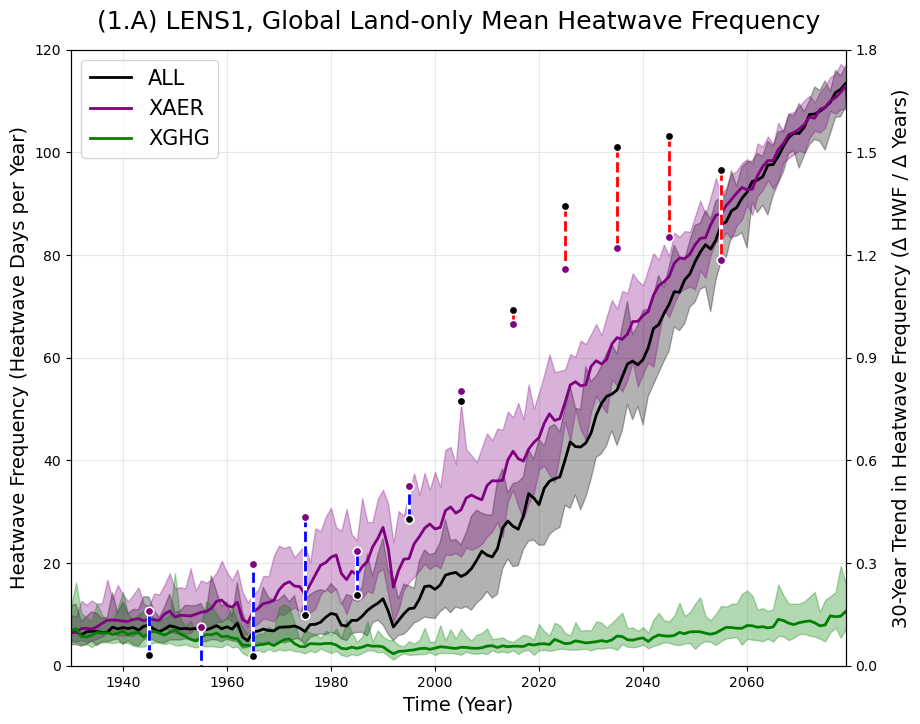

In [14]:
f_background_color = "#ffffff"
ax_background_color = "#ffffff"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8
all_color = "Black"
xaer_color = "Purple"
xghg_color = "Green"

regression_centers = np.arange(1945, 2065, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mn_all_ts_slice = hw_mn_all_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mn_xaer_ts_slice = hw_mn_xaer_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mn_all_ts_slice.year.values, hw_mn_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mn_xaer_ts_slice.year.values, hw_mn_xaer_ts_slice.values, 1)

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

for i in np.arange(1940, 2080, 20):
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in np.arange(0, 120, 20):
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

hw_mn_all_ts["HWF"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
hw_mn_xaer_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mn_xghg_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

a = 0.3
ax1.fill_between(hw_mn_all_ts["HWF"].year.values, hw_mn_all_ts["HWF"].min(dim="member"), hw_mn_all_ts["HWF"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mn_xaer_ts["HWF"].year.values, hw_mn_xaer_ts["HWF"].min(dim="member"), hw_mn_xaer_ts["HWF"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_xghg_ts["HWF"].year.values, hw_mn_xghg_ts["HWF"].min(dim="member"), hw_mn_xghg_ts["HWF"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)

s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

ax11.set_yticks(np.arange(0, 2, 0.3))
ax11.set_ylim(0, 1.8)
ax11.set_ylabel("30-Year Trend in Heatwave Frequency (Δ HWF / Δ Years)", fontsize=14, labelpad=10)

ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 120)
ax1.set_title("(1.A) LENS1, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Frequency (Heatwave Days per Year)", fontsize=14)

f.show()

Text(0, 0.5, 'Δ Heatwave Frequency (Δ Heatwave Days per Year)')

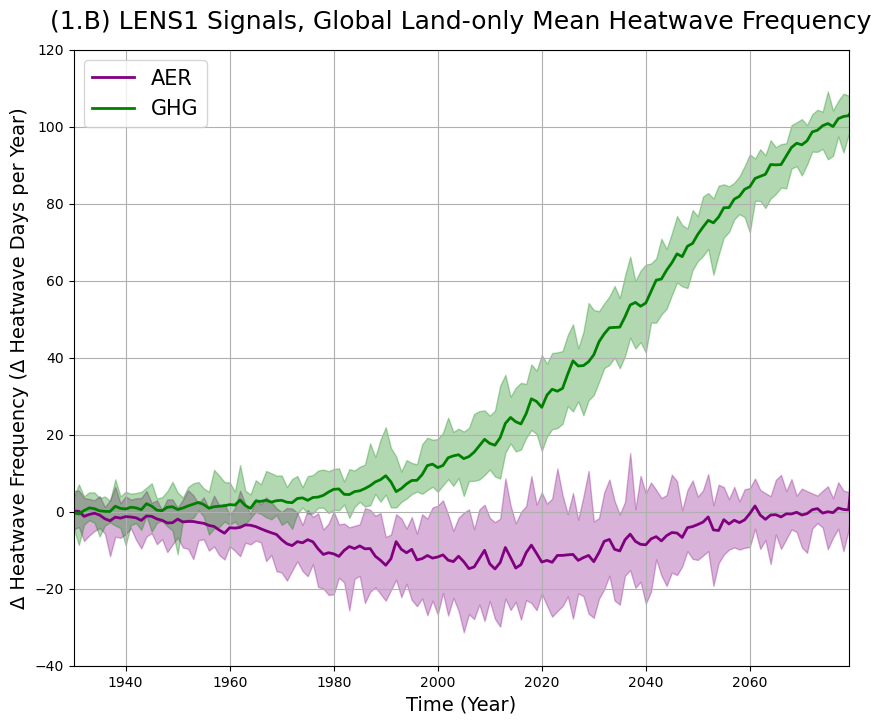

In [15]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mn_aer_ts = hw_mn_all_ts["HWF"] - hw_mn_xaer_ts["HWF"]
hw_mn_ghg_ts = hw_mn_all_ts["HWF"] - hw_mn_xghg_ts["HWF"]

hw_mn_aer_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
hw_mn_ghg_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

a = 0.3
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_aer_ts.min(dim="member"), hw_mn_aer_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_ghg_ts.min(dim="member"), hw_mn_ghg_ts.max("member"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-40, 120)
ax1.set_title("(1.B) LENS1 Signals, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Frequency (Δ Heatwave Days per Year)", fontsize=14)